In [3]:
import numpy as np
import matplotlib.pyplot as plt

import gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
import gala.integrate as gi
from gala.units import galactic

import astropy
import astropy.units as u

In [4]:
%matplotlib inline

## Units in python! (very briefly)

In [99]:
import astropy.units as u

print(u.km)
print(3 * u.km)

km
3.0 km


In [125]:
a = 5*u.km
print(a)
print(a.value)

5.0 km
5.0


In [104]:
print(a.to(u.m))
print(a.cgs)

5000.0 m
500000.0 cm


In [111]:
from astropy.constants import G

G

<<class 'astropy.constants.codata2018.CODATA2018'> name='Gravitational constant' value=6.6743e-11 uncertainty=1.5e-15 unit='m3 / (kg s2)' reference='CODATA 2018'>

In [112]:
print(G.cgs)

6.674299999999999e-08 cm3 / (g s2)


### Defining Our Galaxy Potential using Gala

In [113]:
# define galaxy mass and core radius
M = 1e12 * u.Msun
c = 15 * u.kpc

pot = gp.HernquistPotential(m=M, c=c, units=galactic)
#pot = gp.MilkyWayPotential()

I will now follow approximately what is done in https://gala.adrian.pw/en/latest/dynamics/mockstreams.html

### Creating a stream that starts as a cluster

First we need to define where the progenitor starts to tidally strip by defining its phase space position. I'm going to choose some initial conditions that will give us a stream in 3D (this just means having either the z position or z velocity not 0).

In [114]:
# specify the phase space position (position and velocity coordinates) of the progenitor
progenitor_pos= [30, 0, 10.] * u.kpc
progenitor_vel= [0, 170, 0.] * u.km/u.s
progenitor_w0 = gd.PhaseSpacePosition(pos=progenitor_pos,
                                      vel=progenitor_vel)

Streams have to be created within host galaxy potentials (in this case we are using the Hernquist potential). In general, these potentials do not have to be static; they can change over time (e.g. rotation, acceleration). An example of this in our own Milky Way is that the potential is changing as a result of the infalling Large Magellanic Cloud (LMC).

Because of this possible change in the potential, it is sometimes important to define the potential including a reference frame, so that we can more accurately understand orbits. If you are interested in learning more about this, I encourage you to check out https://gala.adrian.pw/en/latest/potential/hamiltonian-reference-frames.html which describes the use of the Hamiltonian in more detail.

For our purposes in this tutorial, the Hamiltonian is not necessary. But you may wish to keep it in mind and consider whether it will be useful in future stream generations.

In [115]:
H = gp.Hamiltonian(pot)

We now need to specify the way in which particles are released into the stream by defining the *stream distribution function*. Put simply, a distribution function (DF) describes how objects are arrranged. If you know what DF you want, it can also be used to *prescribe* how objects should be arranged, which is what we are doing in this case. We will use the Fardal distribution function from a paper in 2015. There is no need to go deeper into this for our purposes here, but if you are interested you can find the relevant paper here: https://arxiv.org/abs/1410.1861

There are also a couple of other distribution functions that can be used for this purpose that are described in the following papers: https://arxiv.org/abs/1111.5013, https://arxiv.org/abs/1406.2243.
If you are interested in seeing their differences, I encourage you to try re-running the code using `df = gd.mockstream.LagrangeCloudStreamDF()` or `df = gd.mockstream.StreaklineStreamDF()`

We also choose the progenitor mass of the globular cluster or dwarf galaxy that will create the stream here.

In [116]:
df = gd.mockstream.FardalStreamDF()
progenitor_mass = 5e4 * u.Msun

This is all we need to create our stream. We will abandon the Hamiltonian for our simple case here but I've included how it would be used in a comment.

In [117]:
#gen = gd.mockstream.MockStreamGenerator(df, H)
gen = gd.mockstream.MockStreamGenerator(df, pot)

The only remaining things to specify are time related. You must pass in a timestep (don't forget units) and can either accompany it with the number of timesteps or with the initial and final times. I've commented out code for the initial and final time version.

In [118]:
# this is what creates the stream and will store it in the stream object
#stream, prog = gen.run(progenitor_w0, progenitor_mass,
#                       dt=1 * u.Myr, t1=0*u.Myr, t2=1*u.Gyr)
stream, prog = gen.run(progenitor_w0, progenitor_mass,
                       dt=1 * u.Myr, n_steps=2000)

Let's see what we made! We can use the built in plot function to do this.

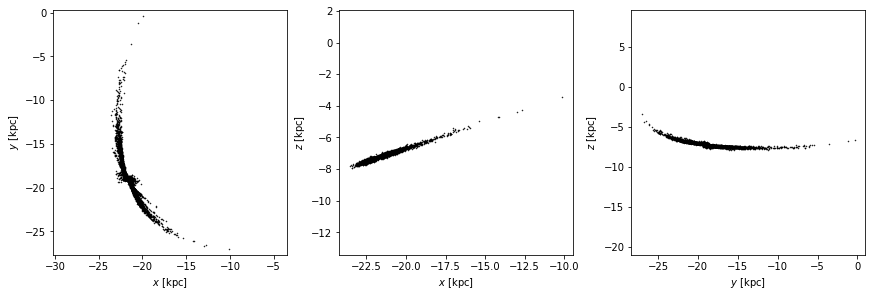

In [119]:
stream.plot(c='k', s=1)
plt.show()

We can quickly see how the particles are released in this code by printing the release times and then printing whether they are in the leading or trailing tail.

In [133]:
with np.printoptions(threshold=5000):
    print(stream.release_time[:100]) # in Myr
print(stream.lead_trail)

[ 0.  0.  1.  1.  2.  2.  3.  3.  4.  4.  5.  5.  6.  6.  7.  7.  8.  8.
  9.  9. 10. 10. 11. 11. 12. 12. 13. 13. 14. 14. 15. 15. 16. 16. 17. 17.
 18. 18. 19. 19. 20. 20. 21. 21. 22. 22. 23. 23. 24. 24. 25. 25. 26. 26.
 27. 27. 28. 28. 29. 29. 30. 30. 31. 31. 32. 32. 33. 33. 34. 34. 35. 35.
 36. 36. 37. 37. 38. 38. 39. 39. 40. 40. 41. 41. 42. 42. 43. 43. 44. 44.
 45. 45. 46. 46. 47. 47. 48. 48. 49. 49.] Myr
['t' 'l' 't' ... 'l' 't' 'l']


We can also use our matplotlib skills to make other plots using the `stream` object, some of which you may recognize from previous assignments.

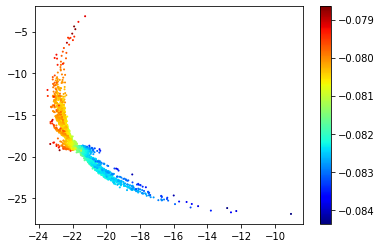

In [13]:
# plotting the energy of each particle
plt.scatter(stream.x.value, stream.y.value, c=stream.energy(pot).value, s=1, cmap='jet')
plt.colorbar()

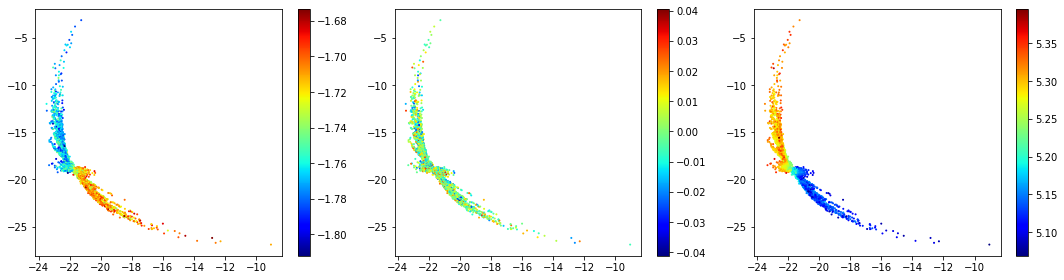

In [14]:
# plotting the release time of each particle
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 4))

im1 = ax1.scatter(stream.x.value, stream.y.value, c=stream.angular_momentum()[0].value, 
            s=1, cmap='jet')
fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(stream.x.value, stream.y.value, c=stream.angular_momentum()[1].value, 
            s=1, cmap='jet')
fig.colorbar(im2, ax=ax2)

im3 = ax3.scatter(stream.x.value, stream.y.value, c=stream.angular_momentum()[2].value, 
            s=1, cmap='jet')
fig.colorbar(im3, ax=ax3)
fig.tight_layout()

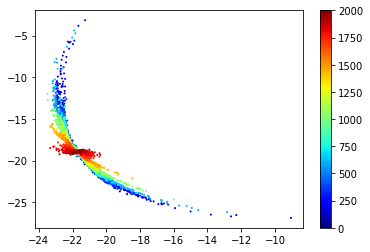

In [15]:
# plotting the release time of each particle
plt.scatter(stream.x.value, stream.y.value, c=stream.release_time.value, s=1, cmap='jet')
plt.colorbar()

### Create a stream from the current progenitor location

This will be more useful for our purposes but I'm going to be less detailed than above and just give code.

But conceptually let me try to explain what this code is doing: We are giving it a current phase space position for the progenitor of the stream and telling it that the progenitor has already been tidally stripping and forming a stream, which we also see today. So we would like to use the same method as above, but we want our starting point to be in "negative" time, and our ending point to be zero. 

To do this, we take the progenitor, which is one object with one phase space coordinate and we evolve it backwards in the host potential. The details of this are simple. You can simply take the negative of the current velocities and pretend you are evolving it forwards. 
We have to choose an amount of time to evolve it backwards for and once it gets there, the code will run just like it does above. The phase space position from your backwards integrated progenitor becomes the initial conditions, and it is evolved forwards from there with MockStreamGenerator.

This entire process is coded into the MockStreamGenerator function and will happen automatically if you make your timestep $<0$

In [97]:
stream_prog_pos= [30, 0, 10.] * u.kpc
stream_prog_vel= [0, 170, 0.] * u.km/u.s
stream_prog_w0 = gd.PhaseSpacePosition(pos=stream_prog_pos,
                                      vel=stream_prog_vel)
stream_prog_mass = 5e4 * u.Msun
stream_prog_pot = gp.PlummerPotential(m=stream_prog_mass, b=4*u.pc, units=galactic)
gen_stream = gd.mockstream.MockStreamGenerator(df,pot,progenitor_potential=stream_prog_pot)
stream, _ = gen_stream.run(stream_prog_w0, stream_prog_mass,
                              dt=-1 * u.Myr, n_steps=2000)

Let's plot our stream as we "see" it currently. Note the difference from the stream in the previous section which is on the same orbit, but taken 2 Gyr in the future.

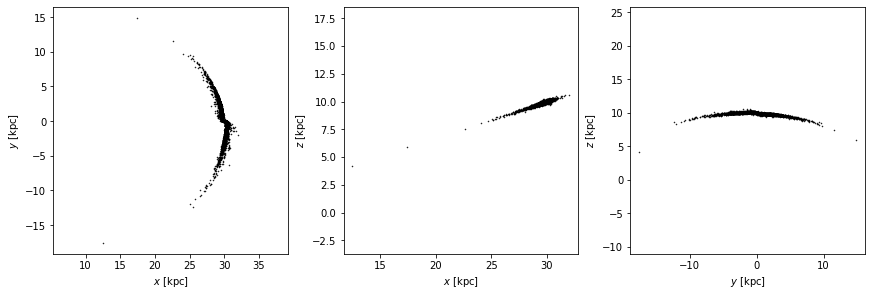

In [19]:
stream.plot(c='k', s=1)
plt.show()

## Using Different Coordinate Systems

We can plot the same stream in many different coordinate systems and generally there are different use cases for each one.

For instance, we have mostly been plotting streams in Galactocentric coordinates, which places the center of the galaxy at (0,0,0). This let's us clearly see how the orbit goes around the center of the potential and gives a good 3D view of the system.

However, when astronomers take data of the sky, that data is usually in two dimensions, with distance sometimes included. One common 2D system that is used is the ICRS coordinate system with coordinates given by (Right Ascension (RA), Declination (Dec)). Most descriptions of real streams in papers will use these coordinates and you may have to get used to them.

Finally, with streams, sometimes it can be useful to think about them as one-dimensional objects. Because they approximate an orbit, it is possible to rotate your coordinate frame such that the "long axis" of the stream lies horizantally. This corresponds to stream coordinate systems, usually denoted by $(\phi_1, \phi_2)$. The idea is that $\phi_2 \approx 0$ along the stream, which can make calculations easier.

These conversions may seem complicated, but luckily there are tools built into astronomy packages that allow for easy use. The most widely used of these is `astropy.coordinates` and the documentation is here: https://docs.astropy.org/en/stable/coordinates/index.html

In [76]:
import astropy.coordinates as coord

Let's define an object in Galactocentric coordinates as above. The way we do this is `astropy.coordinates` is:

In [78]:
#Let's use the same phase space position as the progenitor from the above examples
#progenitor_pos= [30, 0, 10.] * u.kpc
#progenitor_vel= [0, 170, 0.] * u.km/u.s
coord_G = coord.Galactocentric(x=30*u.kpc, y=0*u.kpc, z = 10*u.kpc,
                               v_x=0*u.km/u.s, v_y=170*u.km/u.s, v_z=0*u.km/u.s)

Now let's transform this to a few different coordinate systems:

In [92]:
print(coord_G.transform_to(coord.ICRS), '\n')
print(coord_G.transform_to(coord.Galactic), '\n')
print(coord_G.transform_to(gc.GD1), '\n')
print(coord_G.transform_to(gc.Pal5), '\n')
print(coord_G.transform_to(gc.SagittariusLaw10), '\n')
print(coord_G.transform_to(gc.OrphanKoposov19))

<ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
    (252.9250917, -20.55748663, 39.40646249)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-0.22581914, -0.33661185, -14.44970181)> 

<Galactic Coordinate: (l, b, distance) in (deg, deg, kpc)
    (7.55574394e-05, 14.81583229, 39.40646249)
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-0.40469975, -0.02280196, -14.44970181)> 

<GD1Koposov10 Coordinate: (phi1, phi2, distance) in (deg, deg, kpc)
    (91.52111803, -54.29029189, 39.40646249)
 (pm_phi1_cosphi2, pm_phi2, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0.22343737, -0.33819752, -14.44970182)> 

<Pal5PriceWhelan18 Coordinate: (phi1, phi2, distance) in (deg, deg, kpc)
    (-8.20537043, 30.04792006, 39.40646272)
 (pm_phi1_cosphi2, pm_phi2, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0.37987735, 0.14140373, -14.44970202)> 

<SagittariusLaw10 Coordinate: (Lambda, Beta, distance) in (deg, deg, kpc)
    (

So what if you have data in one coordinate system and you want to use mockstream. You have to convert it to Galactocentric coordinates first. See the example below, where I create a stream from some fake current progenitor location on the sky.

In [93]:
stream_prog_c = coord.SkyCoord(ra=50*u.degree, dec=-10*u.degree,
                        distance=20*u.kpc,
                        pm_ra_cosdec=3*u.mas/u.yr, # proper motion in ra
                        pm_dec=2*u.mas/u.yr, # proper motion in dec
                        radial_velocity=-40*u.km/u.s)

#astropy then allows you to transform the coordinates to Galactocentric ones
#  which we need in order to use MockStream
rep = stream_prog_c.transform_to(coord.Galactocentric).data

# this now creates our PhaseSpacePosition object
stream_w0 = gd.PhaseSpacePosition(rep)

# and we can recreate the stream as before
stream_prog_mass = 5e4 * u.Msun
stream_prog_pot = gp.PlummerPotential(m=stream_prog_mass, b=4*u.pc, units=galactic)
gen_stream = gd.mockstream.MockStreamGenerator(df,pot,progenitor_potential=stream_prog_pot)
stream, prog = gen_stream.run(stream_w0, stream_prog_mass,
                              dt=-1 * u.Myr, n_steps=1500)

In order to check that this stream has the progenitor in the correct place, we should convert back to ra, dec coordinates (called ICRS). We can do that using astropy coordinates again. Notice that the syntax is slightly different in this case than in the above. This is just because we are now converting a MockStream object rather than a PhaseSpacePosition object.

In [94]:
ICRS_stream = stream.to_coord_frame(coord.ICRS)
ICRS_prog = prog.to_coord_frame(coord.ICRS)

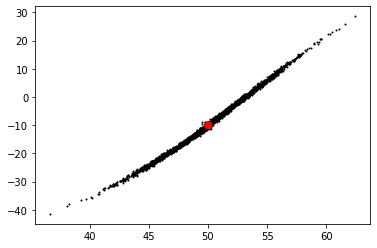

In [95]:
plt.scatter(ICRS_stream.ra, ICRS_stream.dec, c='k', s=1)
plt.scatter(ICRS_prog.ra, ICRS_prog.dec, c='r', s=50)